# Appendix A code

This appendix is designed to equip you with the necessary skills and knowledge to put deep learning into practice and implement large language models (LLMs) from scratch.

In [25]:
import torch

print(torch.__version__)

2.9.0


In [26]:
import torch

print(f"Torch version: {torch.__version__}",)
print(f"Torch MPS Available: {torch.mps.is_available()}")
print(f"Torch Cuda Available: {torch.cuda.is_available()}")
print(f"Torch device: {torch.device('mps')}")
print(f"Torch device count: {torch.cuda.device_count()}")


Torch version: 2.9.0
Torch MPS Available: True
Torch Cuda Available: False
Torch device: mps
Torch device count: 0


## Understanding tensors
### Scalars, vectors, matrices, and tensors

In [27]:
import torch

tensor0d = torch.tensor(1)
tensor1d = torch.tensor([1, 2, 3])
tensor2d = torch.tensor([[1, 2], [3, 4]])

tensor3d = torch.tensor([[[1, 2], [3, 4]],[[5, 6], [7, 8]]])

print(f"tensor0d Creates a zero-dimensional tensor (scalar) from a Python integer:\n{tensor0d}")
print(f"tensor1d Creates a one-dimensional tensor (vector) from a Python list: \n {tensor1d}")
print(f"tensor2d Creates a two-dimensional tensor (matrix) from a Python list of lists :\n {tensor2d}")
print(f"tensor3d Creates a three-dimensional tensor (tensor) from a Python list of lists of lists\n : {tensor3d}")

tensor0d Creates a zero-dimensional tensor (scalar) from a Python integer:
1
tensor1d Creates a one-dimensional tensor (vector) from a Python list: 
 tensor([1, 2, 3])
tensor2d Creates a two-dimensional tensor (matrix) from a Python list of lists :
 tensor([[1, 2],
        [3, 4]])
tensor3d Creates a three-dimensional tensor (tensor) from a Python list of lists of lists
 : tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])


### Tensor data types

PyTorch adopts the default 64-bit integer data type from Python. We can access the data type of a tensor via the `.dtype` attribute of a tensor

In [28]:
tensor1d = torch.tensor([1, 2, 3])
print(tensor1d.dtype)

torch.int64


When we create tensors from Python floats, PyTorch creates tensors with a 32-bit precision by default; This choice is primarily due to the balance between precision and computational efficiency. A 32-bit floating-point number offers sufficient precision for most deep learning tasks while consuming less memory and computational resources than a 64-bit floating-point number. Moreover, GPU architectures are optimized for 32-bit computations, and using this data type can significantly speed up model training and inference.

In [29]:
floatvec = torch.tensor([1.0, 2.0, 3.0])

print(floatvec.dtype)

torch.float32


It is possible to change the precision using a tensor’s `.to` method.

In [30]:
floatvec = tensor1d.to(torch.float32)

print(floatvec.dtype)

torch.float32


### Common PyTorch tensor operations

Common PyTorch tensor operations include element-wise arithmetic, indexing, slicing, reshaping, and broadcasting. These operations are fundamental for manipulating tensors and performing computations in deep learning models.


In [31]:
# create new tensors
tensor2d = torch.tensor([[1, 2, 3],
                         [4, 5, 6]])

print(tensor2d)

tensor([[1, 2, 3],
        [4, 5, 6]])


The `.shape` attribute allows us to access the shape of a tensor

In [32]:
print(tensor2d.shape)

torch.Size([2, 3])


We can also use `.reshape` to change the shape of a tensor. Reshaping allows us to rearrange the elements of a tensor into a different shape while keeping the same data. For example, a 2D tensor with shape (2, 3) containing 6 elements can be reshaped into a 1D tensor with shape (6), or a 3D tensor with shape (1, 2, 3). The only requirement is that the total number of elements must remain the same.


In [33]:
print(tensor2d.reshape(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


However, note that the more common command for reshaping tensors in PyTorch is `.view()`. The `.view()` method is similar to `.reshape()`, but it does not create a new tensor; instead, it returns a view of the original tensor with the specified shape. This can be more memory-efficient, especially when working with large tensors.

In [34]:
print(tensor2d.view(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


we can use `.T` to transpose a tensor, which means flipping it across its diagonal.
> Note that this is not the same as reshaping a tensor, as you can see based on the following result

In [35]:
print(tensor2d.T)

tensor([[1, 4],
        [2, 5],
        [3, 6]])


The common way to multiply two matrices in PyTorch is the `.matmul` method

In [36]:
print(tensor2d.matmul(tensor2d.T))
# we can also use @ operator, which achieves the same thing more compactly.
print(tensor2d @ tensor2d.T)

tensor([[14, 32],
        [32, 77]])
tensor([[14, 32],
        [32, 77]])


## Seeing models as computation graphs

PyTorch’s autograd system provides functions to compute gradients in dynamic computational graphs automatically.

The code in the following listing implements the forward pass (prediction step) of a simple logistic regression classifier, which can be seen as a single-layer neural network. It returns a score between 0 and 1, which is compared to the true class label (0 or 1) when computing the loss.

In [37]:
import torch.nn.functional as F #1

y = torch.tensor([1.0]) # 2
x1 = torch.tensor([1.1]) # 3
w1 = torch.tensor([2.2]) # 4
b = torch.tensor([0.0]) # 5
z = x1 * w1 + b # 6
a = torch.sigmoid(z) #7
loss = F.binary_cross_entropy(a, y) #8

2 → True label $y = 1$

3 → Input Feature $x_1 = 1.1$

4 → Weight $w_1 = 2.2$

5 → Bias $b = 0.0$

6 → Net input $z = x_1 \cdot w_1 + b = 1.1 \cdot 2.2 + 0 = 2.42$

7 → Activation $a = \sigma(z) = \frac{1}{1 + e^{-2.42}} \approx 0.918 $

8 → Loss $L = - \left( y \cdot \log(a) + (1 - y) \cdot \log(1 - a) \right) \approx 0.0855$


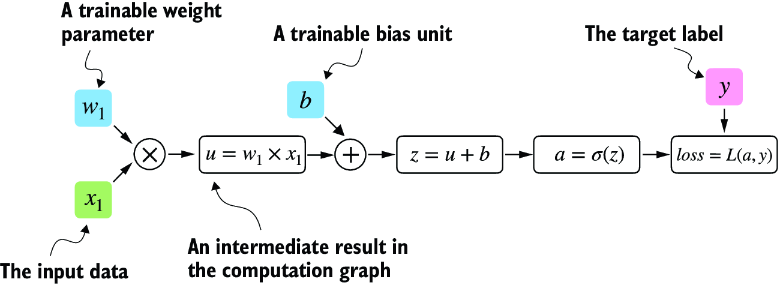
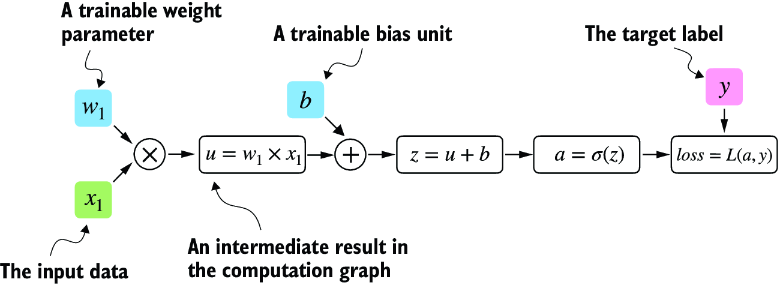